In [1]:
!pip install torchcfm numpy==1.26.4 anndata==0.10.3 scanpy==1.9.6 matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 300 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 8.2 MB/s eta 0:00:011
     |████████████████████████████████| 865 kB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 23.3 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 40.5 MB/s eta 0:00:01
     |████████████████████████████████| 139 kB 45.8 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 39.7 MB/s eta 0:00:01
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successf

In [2]:
import numpy
print(numpy.__version__)

1.26.4


In [1]:
import torch
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('/dss/dsshome1/0F/di93quv/OT-CFM/src/')

from ot_cfm.data_utils import load_adata, create_training_dataloader, create_dataloader
from ot_cfm.model import create_ot_cfm_model
from ot_cfm.training import train_cfm, save_ot_cfm_model, load_ot_cfm_model, create_ot_cfm_optimizer
#from ot_cfm.transport import transport_pooled
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher

In [2]:
# When stuff not reloading properly...
import importlib
import ot_cfm
importlib.reload(ot_cfm)

<module 'ot_cfm' from '/dss/dsshome1/0F/di93quv/OT-CFM/src/ot_cfm/__init__.py'>

In [3]:
# Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# Load target2_moa dataset
target2_moa = load_adata("../data/Tim_target2_wellres_featuresimputed_druginfoadded_pycytominer.h5ad")
target2_moa

AnnData object with n_obs × n_vars = 50640 × 591
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Batch', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_InChIKey_standardized', 'Metadata_SMILES_standardized', 'Metadata_InChI_standardized', 'Metadata_pubchem_cid', 'Metadata_pert_iname', 'Metadata_clinical_phase', 'Metadata_target', 'Metadata_disease_area', 'Metadata_indication', 'Metadata_moa', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Objective_NA', 'Metadata_N_Brightfield_Planes_Min', 'Metadata_N_Brightfield_Planes_Max', 'Metadata_Distance_Between_Z_Microns', 'Metadata_Sites_Per_Well', 'Metadata_Filter_Configuration'
    uns: 'Metadata_Source_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
import torch
torch.cuda.empty_cache()

In [11]:
# Init model
ot_cfm_model = create_ot_cfm_model(adata=target2_moa, use_pca=True, time_varying=True).to(device)
ot_cfm_optimizer = create_ot_cfm_optimizer(ot_cfm_model)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [12]:
ot_cfm_model

MLP(
  (layer1): Linear(in_features=61, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
target2_moa.obs["Metadata_Source"].unique()

['source_10', 'source_11', 'source_13', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8']
Categories (10, object): ['source_2', 'source_3', 'source_4', 'source_5', ..., 'source_8', 'source_10', 'source_11', 'source_13']

### Model:

* OT-CFM model uses an MLP architecture whichh predicts a velocity field for the data transformation It combines input features, one-hot source labels, and (if time_varying=True) a time variable.
* If we set time_varying=True, we add a time dimension to the input.
The MLP thn learns a continuous transformation as a function of time. This enables smooth trajectories when simulating transformations ( via Neural ODE).
* If time_varying=False, then no time variable is added.
The model learns a direct mapping between the source and target distributions, without modeling intermediate states.

In [15]:
# Hyperparameters
epochs = 50  
batch_size = 64

In [8]:
dataloader = create_training_dataloader(
    target2_moa, batch_size=batch_size, exclude_source="source_2", use_pca=True
)

print(next(iter(dataloader))) 

{'source': {'x': tensor([[[-6.0220e+00, -6.4995e+00,  8.6929e-01,  ..., -4.1115e-01,
           7.1370e-01, -1.9077e+00],
         [-3.6116e+00, -5.9208e+00,  1.7286e+00,  ...,  1.0835e+00,
           5.1756e-01, -5.2983e-01],
         [-9.7322e+00,  8.4769e+00, -4.4166e+01,  ...,  8.5406e+00,
           6.5268e+00, -4.2875e+01],
         ...,
         [ 5.0123e-01, -6.3113e+00, -6.5749e-01,  ..., -8.5549e-01,
           6.4677e-01,  9.4284e-02],
         [-1.9343e+01,  2.6704e+01, -5.5496e+01,  ...,  1.3380e+01,
           3.5141e+00, -1.2800e+01],
         [-4.2521e+00, -6.4722e+00,  4.8479e+00,  ..., -1.6394e-01,
           4.5186e+00, -6.4754e-01]],

        [[-3.5876e+00, -6.9156e+00,  1.2211e+00,  ..., -7.9534e-01,
           6.5903e-01,  1.8800e-01],
         [-3.0784e+00, -6.1540e+00,  1.2296e+00,  ...,  3.6560e-01,
           5.5254e-01, -3.9406e-01],
         [-2.1508e+00, -8.8952e+00, -8.8553e-01,  ...,  9.5314e-01,
          -2.6502e+00,  8.6552e-01],
         ...,
        

### Training
The NN learns transformation velocities between pooled source data and the target domain.

Key Steps:
1. Sample batches of source and target data
2. Concatenate data with one-hot source encoding and (if time varying is true) time
3. Predict transformations using the OT-CFM model and compute MSE loss with the target (source 2 here!)
4. Backprop and update the model weights

source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 1/50, Loss: 137.93002319335938


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9, 64, 50])) that is different to the input size (torch.Size([9, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 2/50, Loss: 256.5045471191406
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 3/50, Loss: 460.9184265136719
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 4/50, Loss: 226.2415008544922
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 5/50, Loss: 392.63653564453125
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated i

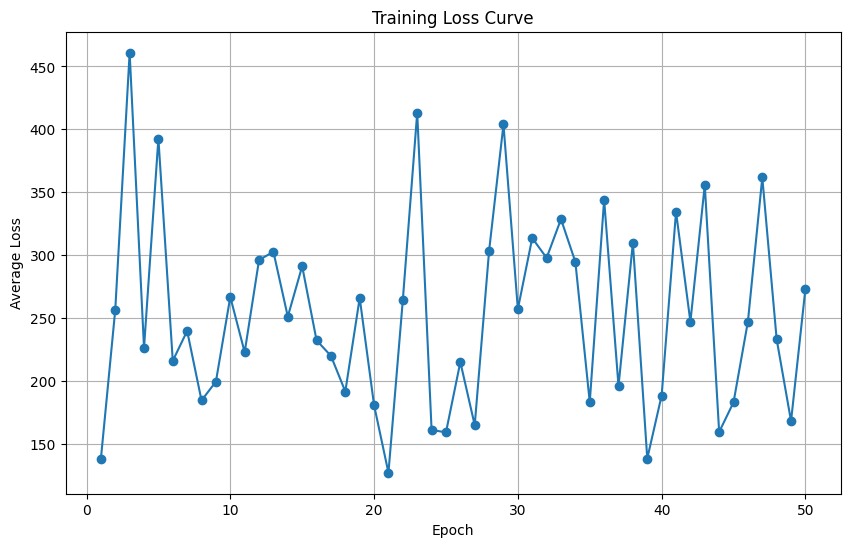

In [9]:
# Training loop 
loss_fn = torch.nn.MSELoss()
all_losses = []  

for epoch in range(epochs):
    epoch_loss = 0.0  
    # Loop over batches from dataloader
    for batch in dataloader:
        # Unpack the batch dictionary
        source_batch = batch["source"]["x"].to(device)
        target_batch = batch["target"]["x"].to(device)
        source_one_hot = batch["source_label"].to(device)

        # Sample time uniformly
        time = torch.rand(source_batch.shape[0]).to(device)  # [64]
        time = time.unsqueeze(-1)  # Shape:[64, 1]

        # Expand time to match
        time = time.unsqueeze(1).expand(-1, 64, -1) 

        # Forward pass
        outputs = ot_cfm_model(source_batch, source_one_hot, time)
        loss = loss_fn(outputs, target_batch)

        # Backpropagation
        ot_cfm_optimizer.zero_grad()
        loss.backward()
        ot_cfm_optimizer.step()

        epoch_loss += loss.item() 

    # Storing average loss for this epoch...
    avg_loss = epoch_loss / len(dataloader)
    all_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

#loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

In [10]:
# save
save_ot_cfm_model(ot_cfm_model, ot_cfm_optimizer, "../results/ot_cfm_pooled.pt")

In [ ]:
# Load the saved model and optimizer
ot_cfm_model, ot_cfm_optimizer = load_ot_cfm_model(ot_cfm_model, ot_cfm_optimizer, "../results/ot_cfm_pooled.pt")

### Transport

1. Transports all sources to a target domain ( source_2)
2. Uses NeuralODE to simulate transformation trajectories
3. Output transformed data in as adata

In [29]:
import numpy as np
import scanpy as sc
from torchdyn.core import NeuralODE
from torchcfm.utils import torch_wrapper
import torch
import torch.nn as nn
import pandas as pd

class TorchWrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""
    def __init__(self, model, c):
        super().__init__()
        self.model = model
        self.c = c  # One-hot encoding of source domain

    def forward(self, t, x, *args, **kwargs):
        # Ensure time has correct shape
        time = t.view(1, 1, 1).repeat(x.shape[0], x.shape[1], 1)  

        # Ensure one-hot encoding is expanded correctly
        source_one_hot = self.c.expand(x.shape[0], x.shape[1], -1) 

        # Debugging: Checking shapes before passing to model...
        print(f"x shape: {x.shape}") 
        print(f"time shape: {time.shape}") 
        print(f"source_one_hot shape: {source_one_hot.shape}") 

        # Pass inpu
        return self.model(x, source_one_hot, time)

In [30]:
import numpy as np
import scanpy as sc
from torchdyn.core import NeuralODE
from torchcfm.utils import torch_wrapper
import torch
import pandas as pd

def transport_pooled(adata, dataloader, ot_cfm_model, target_source="source_2", device="cpu", save_adata_path=None):

    num_sources = len(adata.obs["Metadata_Source"].unique())
    target_idx = list(adata.obs["Metadata_Source"].unique()).index(target_source)
    one_hot_target = torch.eye(num_sources)[target_idx].to(device)

    # Excluding the target source from the dataset (source 2)
    pooled_data = adata[adata.obs["Metadata_Source"] != target_source]

    """Transports data using trained OT-CFM."""
    #ot_cfm_model.to(device) # how we did it in the single source version...
    #node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
    
    # Wrap the model for NeuralODE
    wrapped_model = TorchWrapper(ot_cfm_model, one_hot_target)
    node = NeuralODE(wrapped_model, solver="dopri5", sensitivity="adjoint")

    X_combined, annot_combined = [], pd.DataFrame()

    # Transport all sources (pooled) to the target source
    for batch in dataloader:
        source_batch = batch["source"]["x"].to(device)
        source_moa = batch["source"]["moa"]
        source_cpd = batch["source"]["cpd"]
        source_microscope = batch["source"]["microscope"]

        with torch.no_grad():
            traj = node.trajectory(
                source_batch.float(),
                t_span=torch.linspace(0, 1, 100),
            ).cpu()
        
        x_transported = traj[-1].detach().numpy()
        del traj

        # Concatenate transported and original data
        X_combined.append(np.concatenate([x_transported, source_batch.cpu().numpy()], axis=0))

        # Create annotations for AnnData
        annot1 = {
            "Metadata_Source": [f"{src}_to_{target_source}" for src in batch["source_label"]], 
            "Metadata_moa": source_moa,
            "Metadata_JCP2022": source_cpd,
            "Metadata_Microscope_Name": source_microscope,
        }
        annot2 = {
            "Metadata_Source": [f"{target_source}" for _ in source_moa],  # target source annotation
            "Metadata_moa": source_moa,
            "Metadata_JCP2022": source_cpd,
            "Metadata_Microscope_Name": source_microscope,
        }

        annot_batch = pd.concat([pd.DataFrame(annot1), pd.DataFrame(annot2)], axis=0)
        annot_combined = pd.concat([annot_combined, annot_batch], axis=0)

    # Combine transported data into an AnnData object
    X_combined = np.concatenate(X_combined, axis=0)
    full_adata = sc.AnnData(X=X_combined, obs=annot_combined)
    full_adata.obsm["X_pca"] = full_adata.X.copy()

    if save_adata_path:
        full_adata.write(save_adata_path)

    return full_adata

In [31]:
transported_adata = transport_pooled(
    adata=target2_moa,
    dataloader=dataloader, 
    ot_cfm_model=ot_cfm_model,
    target_source="source_2",
    device="cuda"
)

transported_adata
# transported_adata.write("transported_data_to_source2.h5ad")

x shape: torch.Size([9, 64, 50])
time shape: torch.Size([9, 64, 1])
source_one_hot shape: torch.Size([9, 64, 10])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [ ]:
# Perform PCA and UMAP on transformed AnnData
sc.tl.pca(transformed_adata, n_comps=50)
sc.pp.neighbors(transformed_adata, n_neighbors=15) 
sc.tl.umap(transformed_adata)

# Save the PCA and UMAP results
#transformed_adata.write("../results/transformed_adata_with_embeddings.h5ad")

In [ ]:
# Plot PCA
sc.pl.pca(
    transformed_adata,
    color="Metadata_Source",  
    save="../results/transformed_pca.png",  
    show=True
)

In [ ]:
# Plot UMAP
sc.pl.umap(
    transformed_adata,
    color="Metadata_Source",  
    save="../results/transformed_umap.png",
    show=True
)

### time_varying = True setting 

In [8]:
# Hyperparameters
epochs = 50  
batch_size = 64

In [9]:
# Init model
ot_cfm_model = create_ot_cfm_model(adata=target2_moa, use_pca=True, time_varying=True).to(device)
ot_cfm_optimizer = create_ot_cfm_optimizer(ot_cfm_model)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [10]:
dataloader = create_training_dataloader(
    target2_moa, batch_size=batch_size, exclude_source="source_2", use_pca=True
)

print(next(iter(dataloader))) 

{'source': {'x': tensor([[[-3.0059e+00, -5.6727e+00,  2.8562e+00,  ..., -7.5910e-01,
           1.1704e+00,  3.1966e-02],
         [-2.8562e+00, -7.6748e+00,  4.4586e+00,  ..., -1.7694e-01,
           2.3492e+00,  9.8260e-01],
         [-3.6347e+00, -6.3576e+00,  3.8485e+00,  ..., -2.7000e-02,
           6.1035e-01, -1.5165e+00],
         ...,
         [-2.9766e+00, -8.8894e+00,  2.5813e+00,  ...,  1.5708e-01,
           1.2258e+00,  4.0351e-01],
         [-7.6899e-01, -1.3059e+01,  1.4738e+00,  ..., -7.1514e+00,
           4.8685e-01,  6.9632e+00],
         [-3.3793e+00, -6.8631e+00,  3.8216e-01,  ..., -1.8905e+00,
           3.7944e-01,  3.7694e-02]],

        [[-2.8756e+00, -5.7496e+00,  2.3976e+00,  ...,  3.7150e+00,
          -1.5039e+00, -6.1095e-01],
         [-9.9344e+00, -1.4061e+00,  5.1048e+00,  ...,  3.3070e+00,
           5.5991e+00,  1.1520e+01],
         [-3.3478e+00, -5.0943e+00,  6.1292e-01,  ...,  1.0902e+00,
           1.4066e+00,  8.6822e-02],
         ...,
        

torch.Size([9, 64, 50])
torch.Size([9, 9])
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9, 64, 50])) that is different to the input size (torch.Size([9, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 239.67015075683594
torch.Size([9, 64, 50])
torch.Size([9, 9])
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 2/50, Loss: 228.86904907226562
torch.Size([9, 64, 50])
torch.Size([9, 9])
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 3/50, Loss: 351.53857421875
torch.Size([9, 64, 50])
torch.Size([9, 9])
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: torch.Size([9, 64, 60])
Epoch 4/50, Loss: 127.6219482421875
torch.Size([9, 64, 50])
torch.Size([9, 9])
source_batch shape: torch.Size([9, 64, 50])
source_one_hot shape: torch.Size([9, 64, 9])
time shape: torch.Size([9, 64, 1])
Shape of concatenated input: 

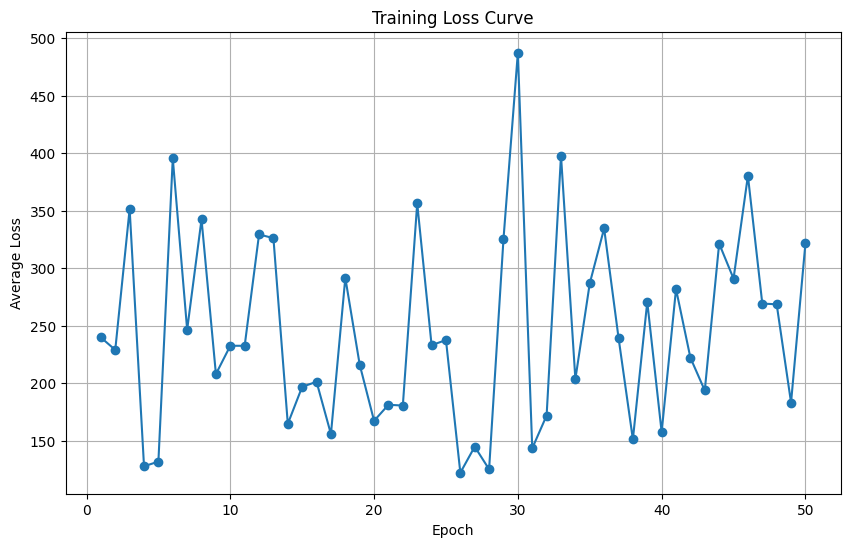

In [11]:
# Training loop 
loss_fn = torch.nn.MSELoss()
all_losses = []  

for epoch in range(epochs):
    epoch_loss = 0.0  
    # Loop over batches from dataloader
    for batch in dataloader:
        # Unpack the batch dictionary
        source_batch = batch["source"]["x"].to(device)
        target_batch = batch["target"]["x"].to(device)
        source_one_hot = batch["source_label"].to(device)
        print(source_batch.shape)
        print(source_one_hot.shape)

        # Sample time uniformly
        time = torch.rand(source_batch.shape[0]).to(device)  # [64]
        time = time.unsqueeze(-1)  # Shape:[64, 1]

        # Expand time to match
        time = time.unsqueeze(1).expand(-1, 64, -1) 

        # Forward pass
        outputs = ot_cfm_model(source_batch, source_one_hot, time)
        loss = loss_fn(outputs, target_batch)

        # Backpropagation
        ot_cfm_optimizer.zero_grad()
        loss.backward()
        ot_cfm_optimizer.step()

        epoch_loss += loss.item() 

    # Storing average loss for this epoch...
    avg_loss = epoch_loss / len(dataloader)
    all_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

#loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()